# Toy Diffusion

This first implementation of our diffusion model will try to generate 2D shapes.

Inspired of this repository and project : https://github.com/ThiagoLira/ToyDiffusion

In [2]:
import torch
import math
import numpy as np
from diffusion import noise_x_t, noise_x_t_with_t_minus_1, train
from utils import pack_data, unpack_1d_data, scatter_pixels

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### Dataset used

We will try to generate a '6' from the mnist dataset converted in 2D.

/home/krabos68/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


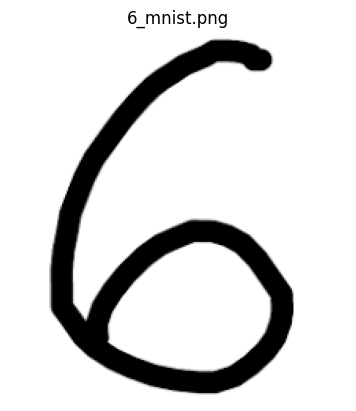

In [3]:
from PIL import Image
import matplotlib.pyplot as plt

img_path = "datasets/2D_ToyDiffusion_data/6_mnist.png"
img = Image.open(img_path)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title("6_mnist.png")
plt.show()

In [4]:
x,y = scatter_pixels('datasets/2D_ToyDiffusion_data/6_mnist.png')
x = [x/25 -3 for x in x]
y = [y/25 -2 for y in y]

Data size: 7492 points


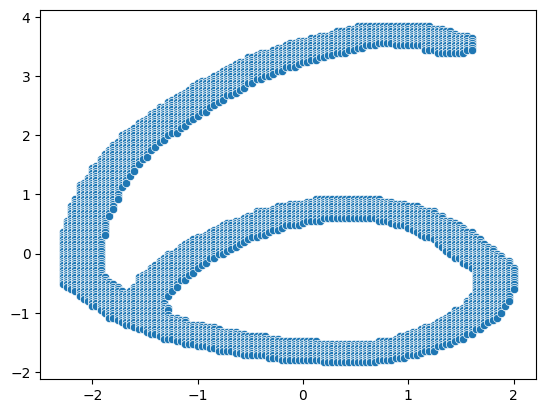

In [5]:
import seaborn as sns
ax = sns.scatterplot(x=x, y=y)

## Store the ax to plot the result later
y_ax = ax.get_ylim()
x_ax = ax.get_xlim()
axes = (x_ax,y_ax)

# send data to device
one_d_data = pack_data(x,y)
x_init = torch.tensor(one_d_data).to(torch.float32).to(device)

DATA_SIZE = len(x_init)
print(f"Data size: {DATA_SIZE} points")

# Noising Exemple Phase

In [50]:
T = 50
beta_list= torch.linspace(0.0001, 0.5, steps=T).to(device)
sigma_list = 1 - beta_list
print(sigma_list)
print(len(sigma_list))

tensor([0.9999, 0.9897, 0.9795, 0.9693, 0.9591, 0.9489, 0.9387, 0.9285, 0.9183,
        0.9081, 0.8979, 0.8877, 0.8775, 0.8673, 0.8571, 0.8469, 0.8367, 0.8265,
        0.8163, 0.8061, 0.7959, 0.7857, 0.7755, 0.7653, 0.7551, 0.7448, 0.7346,
        0.7244, 0.7142, 0.7040, 0.6938, 0.6836, 0.6734, 0.6632, 0.6530, 0.6428,
        0.6326, 0.6224, 0.6122, 0.6020, 0.5918, 0.5816, 0.5714, 0.5612, 0.5510,
        0.5408, 0.5306, 0.5204, 0.5102, 0.5000], device='cuda:0')
50


Création du GIF en cours...


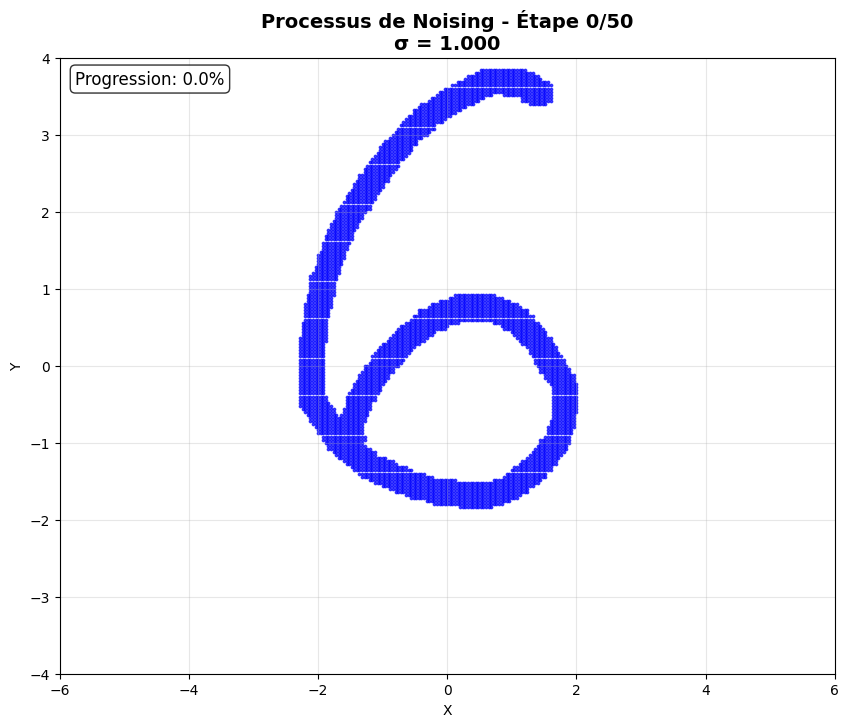

In [42]:
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter

def create_noising_gif():
    fig, ax = plt.subplots(figsize=(10, 8))
    
    def animate(frame):
        ax.clear()
        t = frame
        if t < T:
            noisy_data = noise_x_t_with_t_minus_1(x_init, t, sigma_list)
            x_noisy = noisy_data[0::2].cpu().numpy()
            y_noisy = noisy_data[1::2].cpu().numpy()
            
            ax.scatter(x_noisy, y_noisy, s=3, color='blue', alpha=0.7)
            ax.set_xlim(-6, 6)
            ax.set_ylim(-4, 4)
            sigma_val = sigma_list[t] if t < len(sigma_list) else sigma_list[-1]
            ax.set_title(f'Processus de Noising - Étape {t}/{T}\nσ = {sigma_val:.3f}', 
                        fontsize=14, fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            
            progress = t / T
            ax.text(0.02, 0.98, f'Progression: {progress:.1%}', 
                   transform=ax.transAxes, fontsize=12, 
                   verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    anim = animation.FuncAnimation(fig, animate, frames=T+1, interval=200, repeat=True)
    
    print("Création du GIF en cours...")
    writer = PillowWriter(fps=5)
    anim.save('diffusion_noising_process.gif', writer=writer)    
    return anim

anim = create_noising_gif()

## Model class

In [ ]:
class U_net_simplified(torch.nn.Module):
    def __init__(self, time_emb_dim=64):
        super(U_net_simplified, self).__init__()
        self.fc1 = torch.nn.Linear(2, 64)  
        self.fc2 = torch.nn.Linear(64, 64)
        self.fc3 = torch.nn.Linear(64, 2)  
        
        # Embedding pour le temps: sinusoidal + MLP -> 64-d
        # Using a sinusoidal positional embedding for timesteps is standard
        # in diffusion models and gives smoother generalization across t.
        self.time_emb_dim = time_emb_dim
        self.time_mlp = torch.nn.Sequential(
            torch.nn.Linear(time_emb_dim, 64),
            torch.nn.ReLU(),
        )
        
        self.relu = torch.nn.ReLU()
        
    def sinusoidal_time_embedding(self, t):
        device = t.device
        half = self.time_emb_dim // 2
        
        freqs = torch.exp(
            -math.log(10000.0) * torch.arange(half, device=device).float() / half
        )

        args = t.float().unsqueeze(1) * freqs.unsqueeze(0)
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=1)

        if self.time_emb_dim % 2 == 1:
            emb = torch.cat([emb, torch.zeros((emb.size(0), 1), device=device)], dim=1)

        return emb
        
    def forward(self, x, t):
       
        t_embed = self.sinusoidal_time_embedding(t) 
        t_embed = self.time_mlp(t_embed)  
        
        x = self.relu(self.fc1(x))  
        x = x + t_embed
        x = self.relu(self.fc2(x))
        x = self.fc3(x) 
        
        return x

# Training Phase

In [ ]:
epochs = 100
batch_size = 64
learning_rate = 0.001

# Convertir les données 1D entrelacées en format 2D
# x_init contient [x0, y0, x1, y1, ...] et on veut [[x0, y0], [x1, y1], ...]
x_2d = x_init.reshape(-1, 2)  # Shape: [DATA_SIZE//2, 2]
print(f"Original x_init shape: {x_init.shape}")
print(f"Reshaped x_2d shape: {x_2d.shape}")
print(f"Number of 2D points: {len(x_2d)}")

model = U_net_simplified().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fct = torch.nn.MSELoss()

def train(epochs, batch_size, model, optimizer, loss_fct, data, T, sigma_list):
    """Version modifiée de train pour les données 2D"""
    data_size = len(data)
    
    for epoch in range(epochs):
        model.train()
        perm = torch.randperm(data_size)
        epoch_loss = 0.0
        num_batches = 0

        for i in range(0, data_size, batch_size):
            indices = perm[i : i + batch_size]
            x_batch = data[indices]

            # Étape 2: t ~ U({1, ..., T})
            t = torch.randint(1, T + 1, (len(x_batch),)).to(device)
            
            # Étape 3: bruit ξ_0 ~ N(0, I)
            noise_batch = torch.randn_like(x_batch).to(device)
            
            # Étape 4: x_t = sqrt(α̅_t)x_0 + sqrt(1-α̅_t)ξ_0
            x_noisy_batch = []
            for j, (x_0, t_i, noise) in enumerate(zip(x_batch, t, noise_batch)):
                t_idx = int(t_i.item()) - 1
                alpha_bar_t = float(np.cumprod(sigma_list, axis=0)[t_idx])
                x_t = math.sqrt(alpha_bar_t) * x_0 + math.sqrt(1.0 - alpha_bar_t) * noise
                x_noisy_batch.append(x_t)
            
            x_noisy_batch = torch.stack(x_noisy_batch)

            optimizer.zero_grad()
            
            # Le modèle prédit le bruit ξ_θ(x_t, t)
            predicted_noise = model(x_noisy_batch, t)
            
            # Étape 5: descente de gradient sur ||ξ_0 - ξ_θ(x_t, t)||_2^2
            loss = loss_fct(noise_batch,predicted_noise)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1
        
        avg_loss = epoch_loss / num_batches
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}")

train(epochs, batch_size, model, optimizer, loss_fct, x_2d, T, sigma_list.tolist())

Original x_init shape: torch.Size([7492])
Reshaped x_2d shape: torch.Size([3746, 2])
Number of 2D points: 3746
Epoch [10/100], Loss: 0.2876
Epoch [10/100], Loss: 0.2876
Epoch [20/100], Loss: 0.2605
Epoch [20/100], Loss: 0.2605
Epoch [30/100], Loss: 0.2804
Epoch [30/100], Loss: 0.2804
Epoch [40/100], Loss: 0.2787
Epoch [40/100], Loss: 0.2787
Epoch [50/100], Loss: 0.2739
Epoch [50/100], Loss: 0.2739
Epoch [60/100], Loss: 0.2666
Epoch [60/100], Loss: 0.2666
Epoch [70/100], Loss: 0.2495
Epoch [70/100], Loss: 0.2495
Epoch [80/100], Loss: 0.2657
Epoch [80/100], Loss: 0.2657
Epoch [90/100], Loss: 0.2634
Epoch [90/100], Loss: 0.2634
Epoch [100/100], Loss: 0.2574
Epoch [100/100], Loss: 0.2574


# Generation Phase

Génération en cours avec le nouveau schedule...
Généré 10000 points


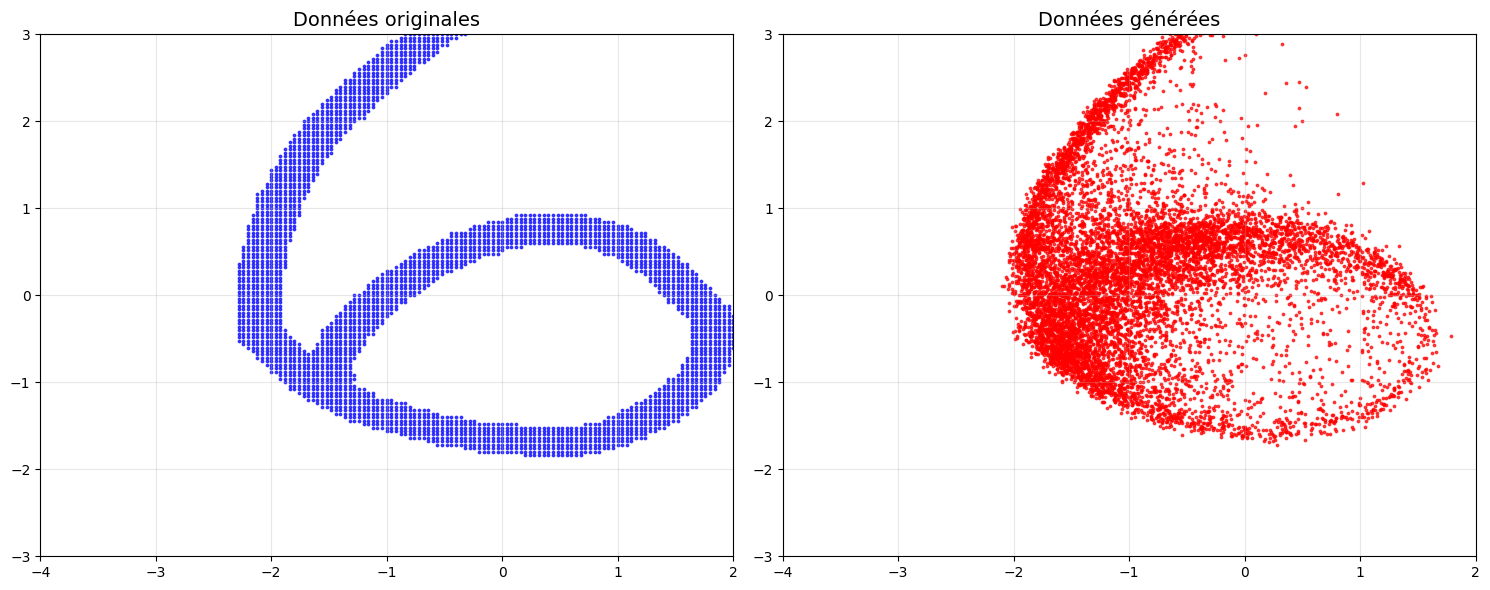

Génération terminée avec succès !


In [ ]:
def generate_samples_corrected(model, num_samples, T, device):
    """Génère des échantillons en inversant le processus de diffusion"""
    model.eval()
    
    # Commencer avec du bruit pur
    x_t = torch.randn(num_samples, 2).to(device)
    
    generated_samples = []
    sigma_bar_list = torch.cumprod(sigma_list, dim=0)
    
    with torch.no_grad():
        # Processus de débruitage de T vers 0
        for t in reversed(range(1, T + 1)):
            # Créer un tensor temps pour tous les échantillons
            t_tensor = torch.full((num_samples,), t, device=device, dtype=torch.long)
            
            # Prédire le bruit
            predicted_noise = model(x_t, t_tensor)
            beta_t = beta_list[t - 1]
            sigma_t= sigma_list[t - 1]
            sigma_bar_t = sigma_bar_list[t - 1]
            z= torch.randn_like(x_t) if t > 1 else torch.zeros_like(x_t)
            # Calculer x_{t-1}
            x_t = (1 / math.sqrt(sigma_t)) * (x_t - (1-sigma_t)/math.sqrt(1 - sigma_bar_t) * predicted_noise)+ beta_t * z
            # Stocker les échantillons intermédiaires pour visualisation
            generated_samples.append(x_t.cpu().numpy())
    
    return x_t, generated_samples

num_samples = 10000
print("Génération en cours avec le nouveau schedule...")
final_samples, intermediate_samples = generate_samples_corrected(
    model, num_samples, T, device
)

final_samples_cpu = final_samples.cpu().numpy()
x_generated = final_samples_cpu[:, 0]
y_generated = final_samples_cpu[:, 1]

print(f"Généré {len(x_generated)} points")

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Original data
x_original = x_2d[:, 0].cpu().numpy()
y_original = x_2d[:, 1].cpu().numpy()
axes[0].scatter(x_original, y_original, s=3, alpha=0.7, color='blue')
axes[0].set_title('Données originales', fontsize=14)
axes[0].set_xlim(-4, 2)
axes[0].set_ylim(-3, 3)
axes[0].grid(True, alpha=0.3)

# Generated data
axes[1].scatter(x_generated, y_generated, s=3, alpha=0.7, color='red')
axes[1].set_title('Données générées', fontsize=14)
axes[1].set_xlim(-4, 2)
axes[1].set_ylim(-3, 3)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Génération terminée avec succès !")